# Annotate Text

In [1]:
import json
import requests
from bs4 import BeautifulSoup
from graphviz import Digraph

from assemble_graph import Graph

### Create Graph from Wikipedia Pages

In [2]:
PAGES = ["Penne_alla_vodka", "Italian_cuisine", "Pizza", "Pasta"]

In [3]:
def text_from_wiki(title):
    url = "https://en.wikipedia.org/wiki/" + title
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    text = ""
    paragraphs = soup.find_all('p')
    for paragraph in paragraphs:
        text += paragraph.get_text() + "\n\n"
    return text

def graph_from_wiki(page_list):
    graph = Graph()
    for page in page_list:
        print(page)
        graph.add_text_to_graph(text_from_wiki(page))
    return json.loads(graph.serialize())

graph_data = graph_from_wiki(PAGES)

Your label namespace was 'pos'. We recommend you use a namespace ending with 'labels' or 'tags', so we don't add UNK and PAD tokens by default to your vocabulary.  See documentation for `non_padded_namespaces` parameter in Vocabulary.


Penne_alla_vodka
Italian_cuisine
Pizza
Pasta


### Annotate Text with Graph

In [4]:
TEXT = '''Piccolo Forno features a menu of Tuscan-style dishes incorporating interesting meats like rabbit
and lamb, while also sporting an interior of traditional design elements including exposed brick. But even
if the heart is set on pasta, which is certainly delicious in its own right, pizza lovers will want to order
a pie from the wood-fired grill. Choose from classics like the margherita with crushed tomatoes and mozzarella,
or more adventurous selections like Tartuffo, topped with asparagus, truffle oil, corn, and egg, or the famed
Capricciosa with crushed tomato, fresh mozzarella, mushroom, artichoke, olive, prosciutto cotto, and egg. And
don’t forget to bring a bottle of wine with you: Piccolo Forno is BYOB.'''

In [5]:
def strip_word(word):
    return ''.join(char for char in word if char.isalpha()).lower()

def tokenize(text):
    return [strip_word(word) for word in text.split()]

In [6]:
def annotate_text(graph_data, query):
    mini_graph = {'nodes': {}, 'relations': {}, 'paragraphs': {}}
    # Get nodes
    for token in tokenize(query):
        if token in graph_data['nodes']:
            mini_graph['nodes'][token] = []
    # Get edges
    for rel in graph_data['relations']:
        node1, node2 = rel.split('/')
        if node1 in mini_graph['nodes'] and node2 in mini_graph['nodes']:
            mini_graph['nodes'][node1].append(node2)
            mini_graph['relations'][rel] = graph_data['relations'][rel]
    return mini_graph

def match_paragraphs(big_graph, little_graph, threshold):
    scores = {}
    for node in big_graph['nodes']:
        if node.isnumeric():
            scores[node] = 0
    for node1 in little_graph['nodes']:
        for node2 in big_graph['nodes'][node1]:
            if node2 in scores:
                scores[node2] += float(graph_data['relations'][node1 + '/' + node2])
    return [paragraph for paragraph in scores if scores[paragraph] > threshold]

def add_paragraphs_to_graph(big_graph, little_graph, paragraphs):
    for node1 in little_graph['nodes']:
        for node2 in big_graph['nodes'][node1]:
            if node2 in paragraphs:
                little_graph['nodes'][node1].append(node2)
                
def visualize(graph_data):
    graph = Digraph()
    for node1 in graph_data['nodes']:
        for node2 in graph_data['nodes'][node1]:
            rel_candidate = node1 + '/' + node2
            if rel_candidate in graph_data['relations']:
                graph.edge(node1, node2, label=graph_data['relations'][rel_candidate])
            else:
                graph.edge(node1, node2)            
    return graph

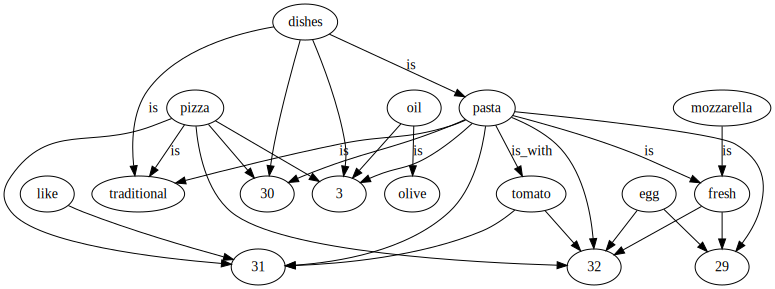

In [7]:
matched_graph = annotate_text(graph_data, TEXT)
paragraphs = match_paragraphs(graph_data, matched_graph, 8)
add_paragraphs_to_graph(graph_data, matched_graph, paragraphs)
visualize(matched_graph)